# Práctica 4. EigenFaces
https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/

# 1. EigenFaces

Antes de aplicar PCA, debemos aplicar un preprocesamiento a las imágenes con las que vamos a trabajar. 

In [1]:
import sys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cargamos las imágenes obtenidas de: [MIT Faces Recognition Project database](https://courses.media.mit.edu/2004fall/mas622j/04.projects/faces/). 

In [3]:
# Motsrar imagen original
def display_face(filename):
    path = '/content/drive/MyDrive/Aux/EigenFaces/rawdata/' + filename
    raw = np.fromfile(path, dtype='uint8', sep="")
    img = np.reshape(raw, (128, 128))
    plt.imshow(img, cmap="gray")

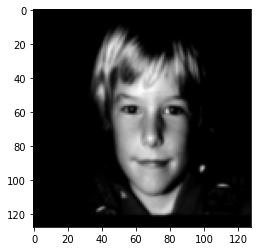

In [4]:
filename="1227"
display_face(filename)

# Carga de datos

Caras Originales

In [5]:
def cargaImagenes(path):
  original_images = []
  i = 0
  print(len(os.listdir(path)))
  for filename in os.listdir(path):
    try:
      #print(filename)
      # Usamos uint8 por que así están codificadas las imagenes
      raw = np.fromfile(path+filename, dtype='uint8', sep="")
      img = np.reshape(raw, (128, 128))
    except FileNotFoundError:
      continue
    #Para omitir imagenes que no pueden ser redimensionadas a 128x128
    except ValueError as e:
      print(e)
      continue
    original_images.append(img)
    i += 1
    if i >= 3500:
      break
  return original_images

In [6]:
#path = '/content/drive/MyDrive/Colab Notebooks/EigenFaces/rawdata/'
#imagenes = cargaImagenes(path)

In [7]:
path = '/content/drive/MyDrive/Aux/EigenFaces/rawdata/'
imagenes = cargaImagenes(path)

3993
cannot reshape array of size 262144 into shape (128,128)
cannot reshape array of size 262144 into shape (128,128)


Imprimimos una muestra de las imágenes cargadas.

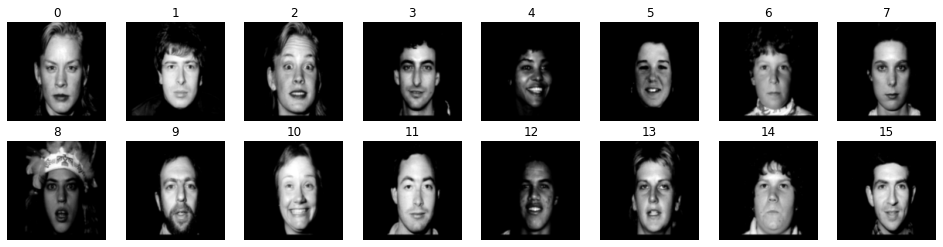

In [8]:
fig, axes = plt.subplots(2,8, figsize=(17,4))
for i in range(16):
  ax = axes.flat[i]
  ax.imshow(imagenes[i], cmap="gray")
  ax.set_title(i)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.axis('off')
fig.subplots_adjust(hspace=0.2, wspace=0);

# Entrenamiento

## Preprocesamiento de las imágenes

Calculamos una "imagen promedio" de todo el conjunto de imágenes. 

In [9]:
imagenes_array = np.array(imagenes)
X = imagenes_array.reshape(imagenes_array.shape[0],128*128)
mean_face = np.mean(X,axis=0)
mean_face.shape

(16384,)

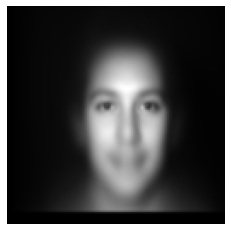

In [10]:
img = np.reshape(mean_face, (128, 128))
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.show()

Obtenemos puntos centrados para aplicar PCA. Para esto, restamos la "imagen promedio" de cada imagen. 

In [11]:
X_centered = X - mean_face.reshape((1,-1))
X_centered.shape

(3500, 16384)

Mostramos la comparación entre la imagen original y la imagen centrada. 

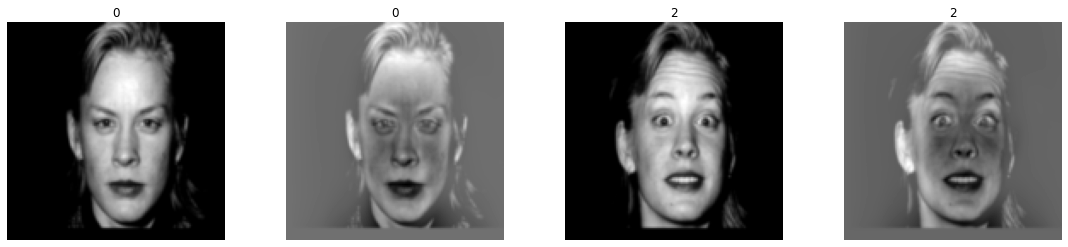

In [12]:
fig, axes = plt.subplots(1,4, figsize=(20,4))
for i in range(0,3,2):
  ax = axes.flat[i]
  ax.imshow(imagenes[i], cmap="gray")
  ax.set_title(i)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.axis('off')

  ax = axes.flat[i+1]
  ax.imshow(X_centered[i].reshape((128,128)), cmap="gray")
  ax.set_title(i)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.axis('off')

fig.subplots_adjust(hspace=0.2, wspace=0)
plt.show()

## PCA

$$X = U \Sigma V^{T}$$

Calculamos la SVD de X y guardamos el resultado en las matrices U, Sigma y VT.

In [ ]:
U, Sigma, V_T = np.linalg.svd(X_centered, full_matrices=False)

In [ ]:
# Imprimimos las dimensiones de las matrices
print("X:", X_centered.shape)
print("U:", U.shape)
print("Sigma:", Sigma.shape)
print("V^T:", V_T.shape)

X: (3500, 16384)
U: (3500, 3500)
Sigma: (3500,)
V^T: (3500, 16384)


Graficamos los componentes principales.

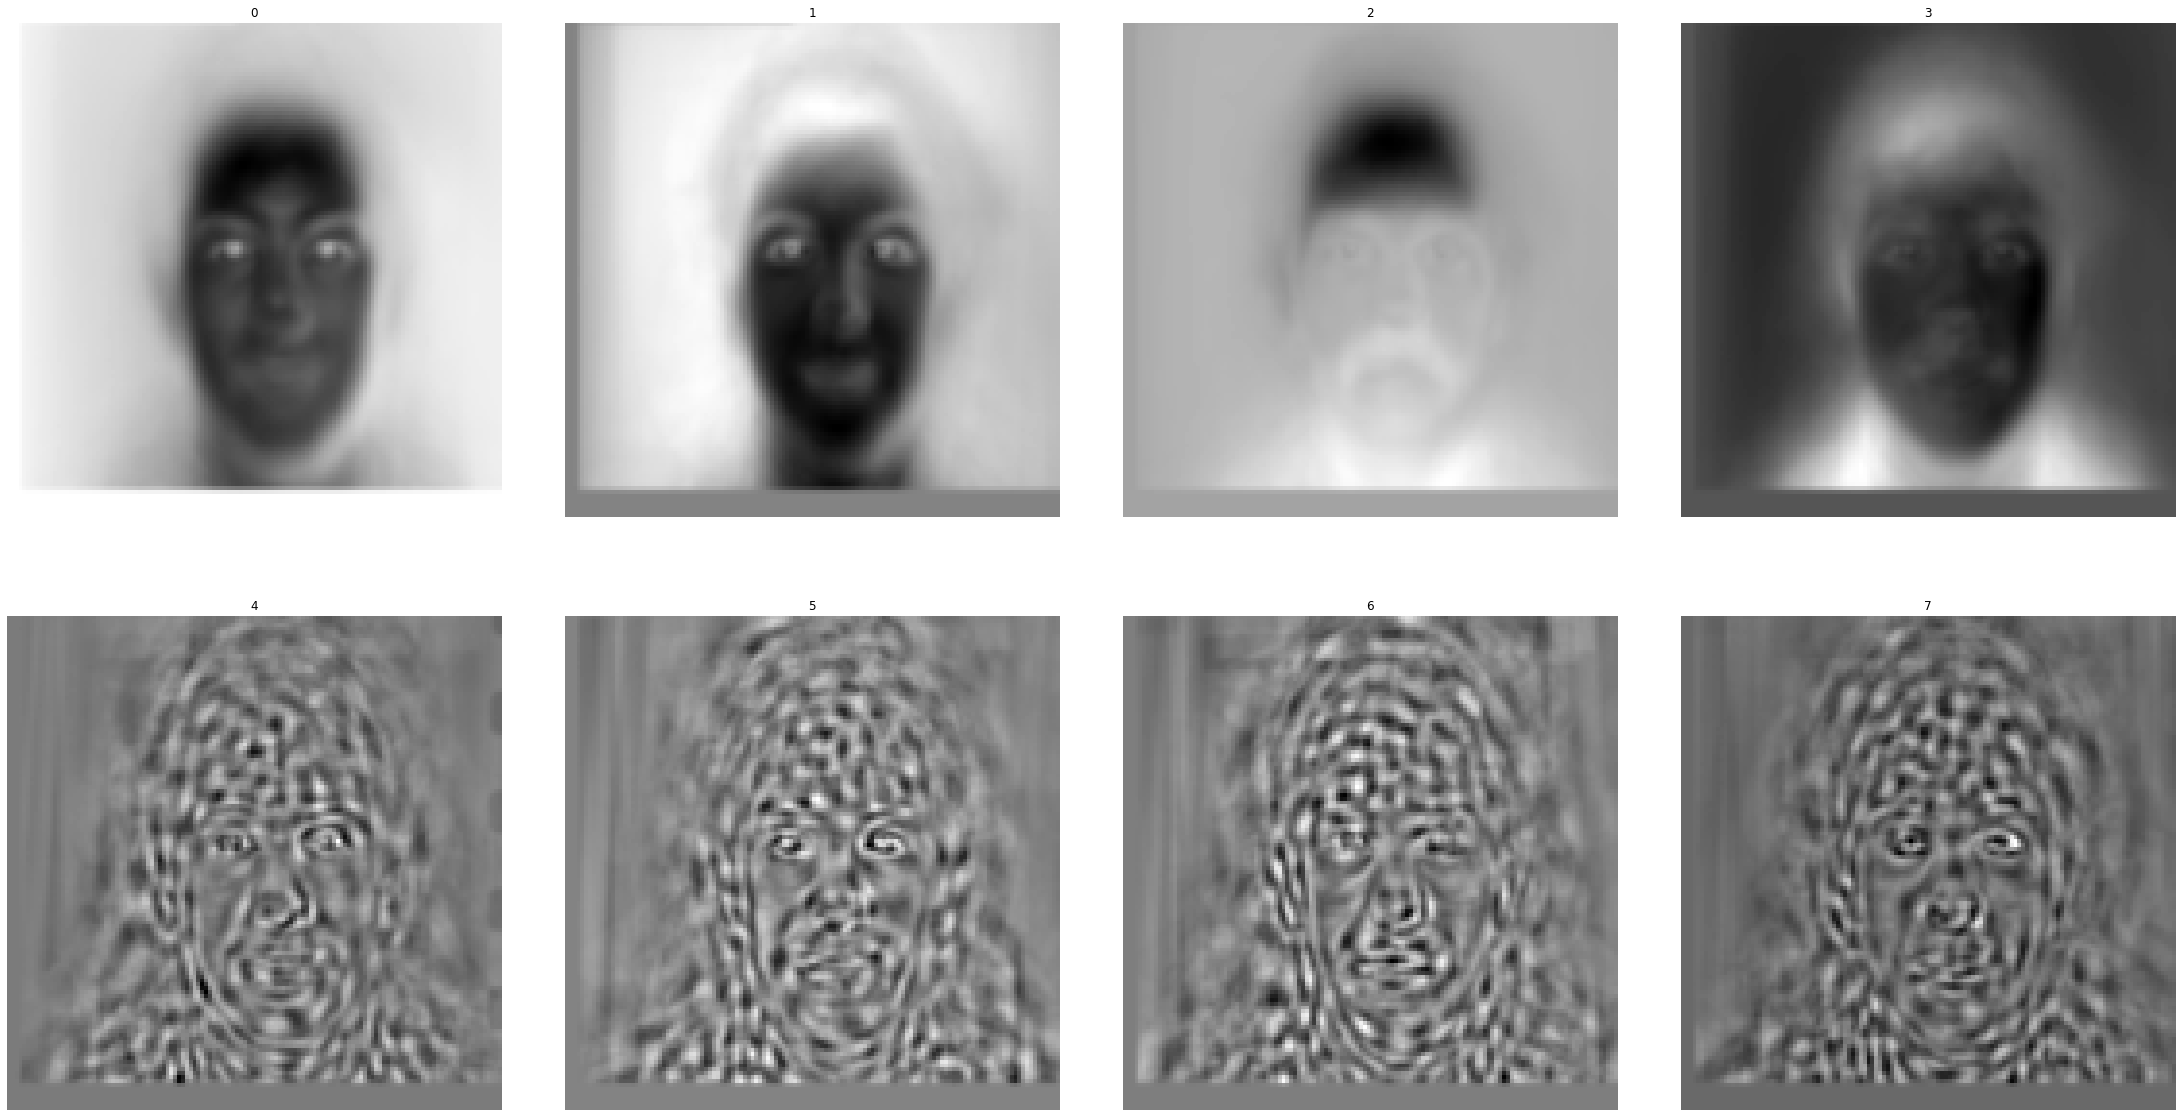

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(40,20))
valores = [0,1,2,3,500,501,502,503]
for i in range(8):
  ax = axes.flat[i]
  ax.imshow(np.reshape(V_T[valores[i]], (128, 128)), cmap="gray")
  ax.set_title(i)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.axis('off')

fig.subplots_adjust(hspace=0.2, wspace=0)
plt.show()

Ahora computamos una nueva matriz Y la cual será la matriz original projectada en las primeros n componentes principales. 

In [ ]:
num_componentes = 5 # Numero de componentes principales
Y = np.matmul(X, V_T[:num_componentes,:].T)

In [ ]:
Y.shape

(3500, 5)

Graficamos, utilizando la librería [Bokeh](https://realpython.com/python-data-visualization-bokeh/) de Python para visualizar los puntos de datos faciales proyectados en las dos primeras componentes principales.

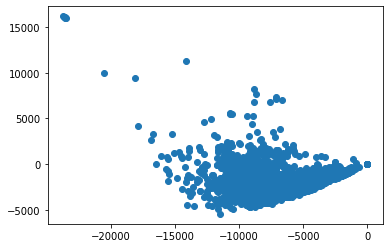

In [ ]:
# Output the visualization directly in the notebook
#output_file('first_glyphs.html', title='First Glyphs')
'''
# Create a figure with no toolbar and axis ranges of [0,3]
fig = figure(title='Y',
             plot_height=300, plot_width=300,
             toolbar_location=None)

# Draw the coordinates as circles
fig.circle(x=Y[:,0], y=Y[:,1],
           color='blue', size=10, alpha=0.5)

# Show plot
show(fig)
'''

plt.scatter(x=Y[:,0], y=Y[:,1])
plt.show("Graficación de los rostros en los primeros 2 componentes")
plt.show()

Aplicamos K-Means sobre los datos proyectados para formar clusters. 

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
m = 500
k = 3
kmeans = KMeans(n_clusters=k).fit(Y[:m, :num_componentes])
CentroidesP = kmeans.cluster_centers_

Graficamos los Clusters.

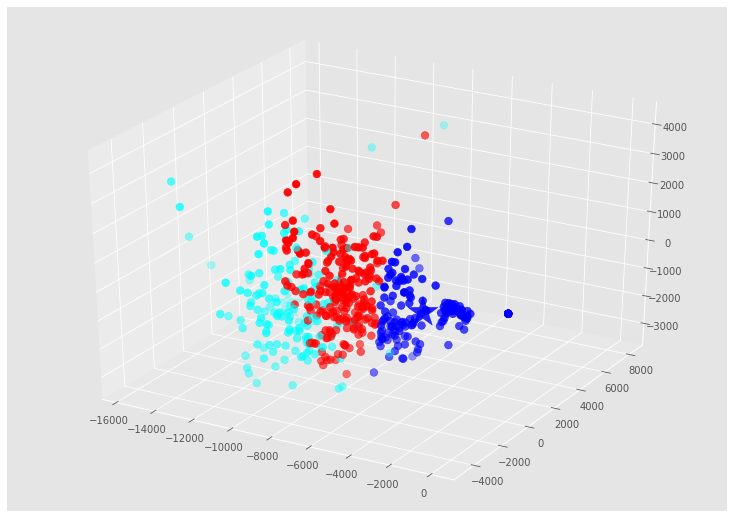

In [ ]:
# Gráfica de los elementos en 3D y los centros de los clusters
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (10, 7)
plt.style.use('ggplot')
colores=['red', 'blue', 'cyan']
asignar=[]
for row in kmeans.labels_:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter (Y[:m,0],Y[:m,1],Y[:m,2], marker='o', c=asignar, s=60)
ax.scatter(CentroidesP[:, 0], CentroidesP[:, 1], CentroidesP[:, 2], marker='*', 
           c=colores, s=1000)
plt.show()

# 2. Reconstrucción facial

Revisar: https://colab.research.google.com/drive/1T3cSvQZjKhh8s3Dxrb9gPCWhwhcz4Bmo#scrollTo=ktT5zKW5WZJK 

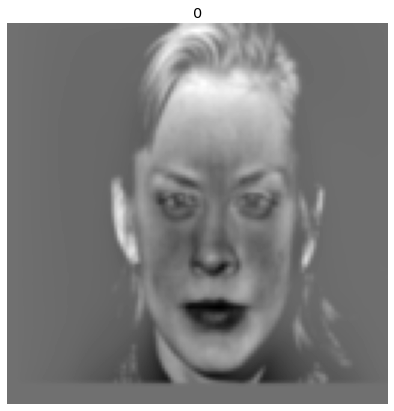

In [ ]:
plt.imshow(np.reshape(X_centered[0], (128, 128)), cmap="gray")
plt.title(0)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
def mulMat(componentes,imagen):
  pc = V_T[:componentes] # (componentes, 12380)
  # imagen (12380, 1)
  # representación (componentes, 1)
  resultado = pc.T@(pc@X_centered[imagen]) 
  fig, axes = plt.subplots(1,2, figsize=(10,5))
  
  ax = axes.flat[0]
  ax.imshow(np.reshape(X_centered[imagen]+mean_face, (128, 128)), cmap="gray")
  ax.set_title("real")
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.axis('off')

  ax = axes.flat[1]
  ax.imshow(np.reshape(resultado+mean_face, (128, 128)), cmap="gray")
  ax.set_title("Eigenfaces: "+str(componentes))
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.axis('off')

  fig.subplots_adjust(hspace=0.2, wspace=0)
  plt.show()

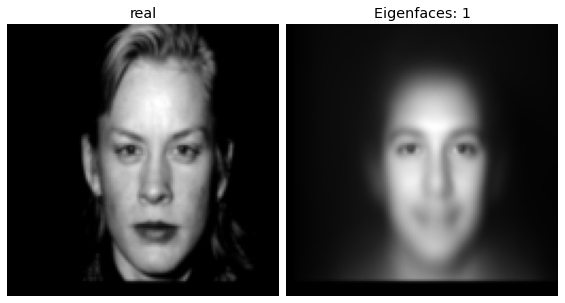

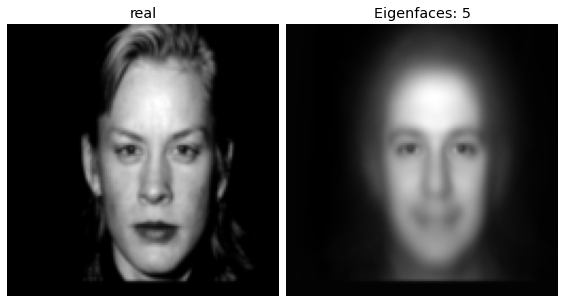

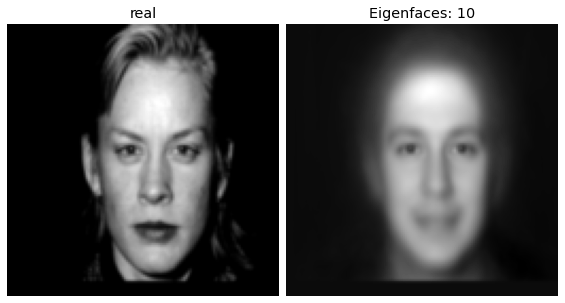

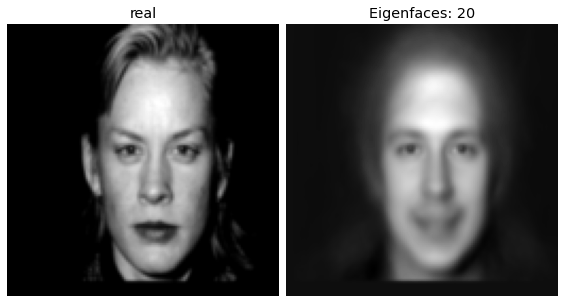

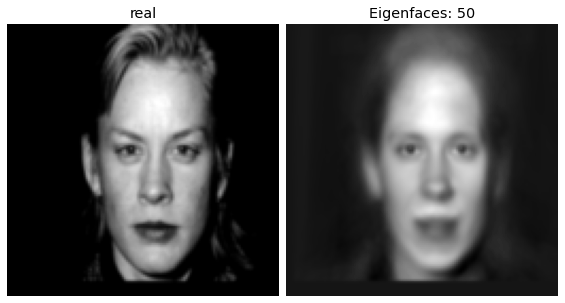

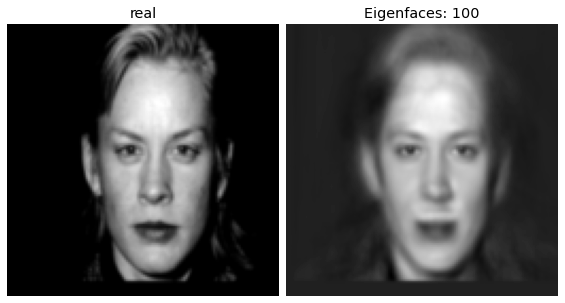

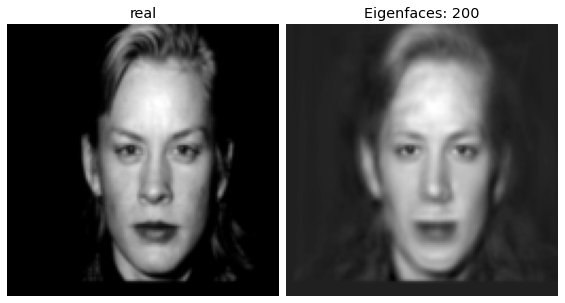

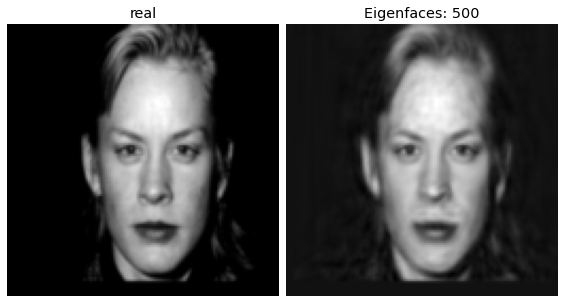

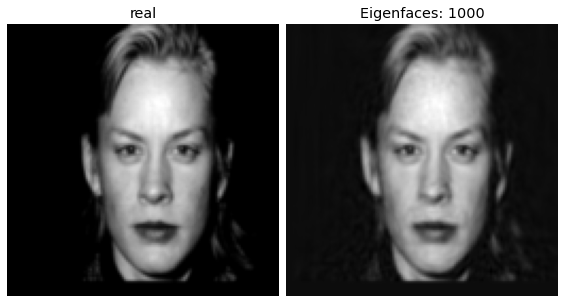

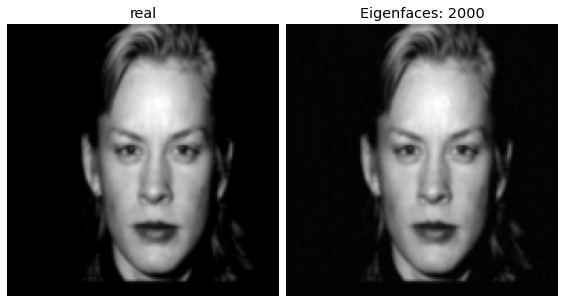

In [ ]:
for i in [1,5,10,20,50,100,200,500,1000,2000]:
  mulMat(i,0)

# Generación de rostros

In [ ]:
print(V_T.shape)
print(V_T.T.shape)
print(X_centered[0].shape)
print(X_centered.shape)

(3500, 16384)
(16384, 3500)
(16384,)
(3500, 16384)


In [ ]:
A = V_T@X_centered[:3000].T
print(np.max(A))
print(np.min(A))

18152.604778284534
-17059.660751092866


In [ ]:
mx = np.max(A, axis=0)
mn = np.min(A, axis=0)

In [ ]:
lista = []
for i in range(3000):
  lista.append(np.random.normal(mn[i],mx[i],[1,1])[0])
ruido = np.array(lista)

In [ ]:
ruido.shape

(3000, 1)

In [ ]:
def generar(componentes,imagen):
  pc = V_T[:componentes]
  resultado = pc.T@imagen[:componentes]
    
  plt.imshow(np.reshape(resultado+mean_face.reshape(128*128,1), (128, 128)), cmap="gray")
  plt.xticks([])
  plt.yticks([])
  plt.title("Generada "+str(componentes))
  plt.show()

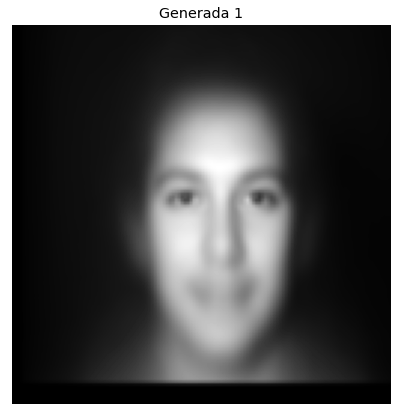

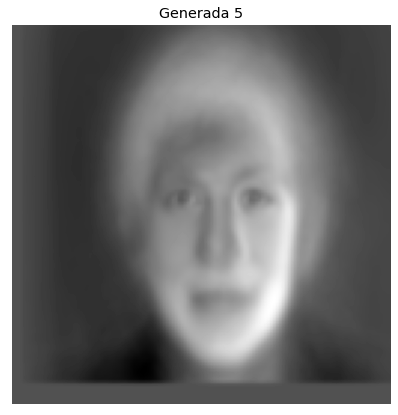

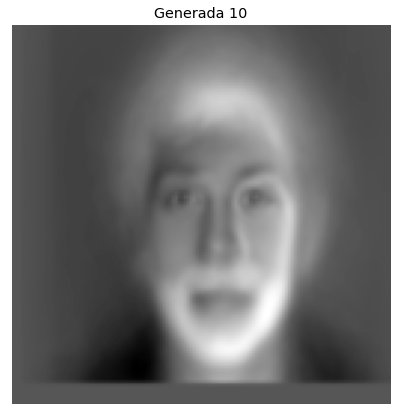

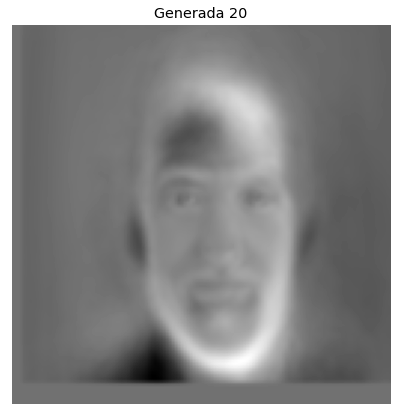

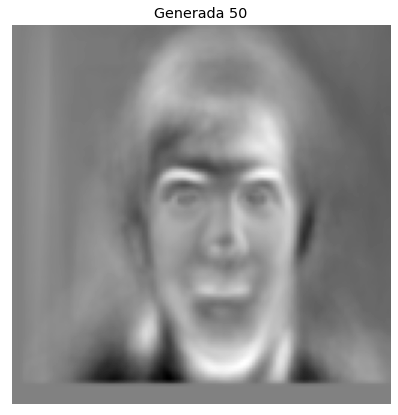

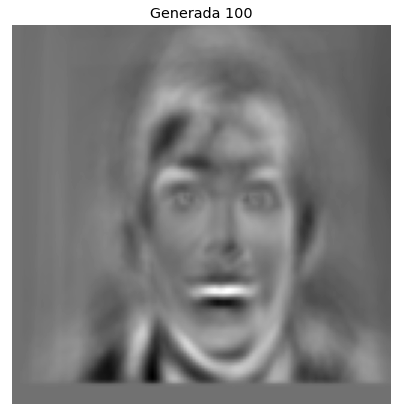

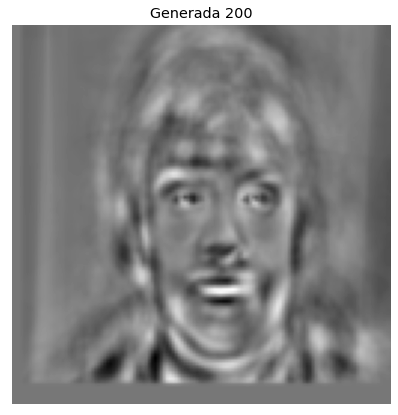

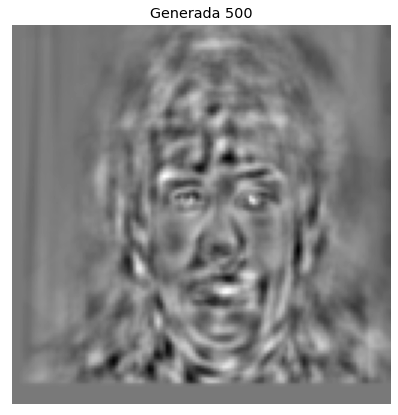

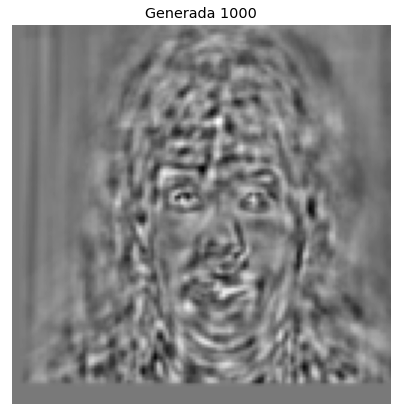

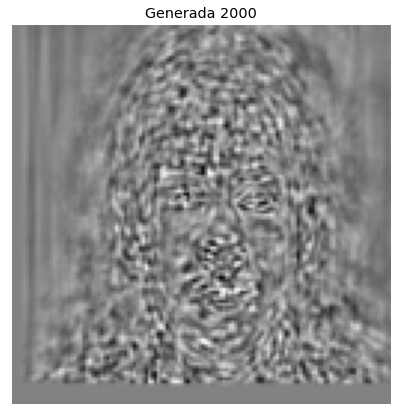

In [ ]:
for i in [1,5,10,20,50,100,200,500,1000,2000]:
  imagen = ruido[:i]
  generar(i,imagen)

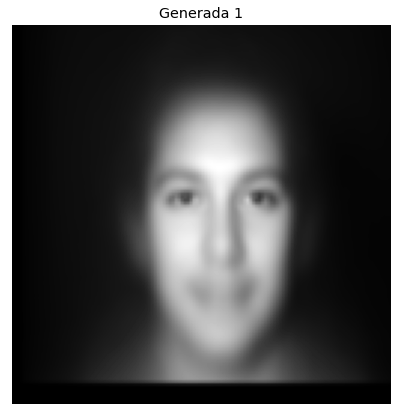

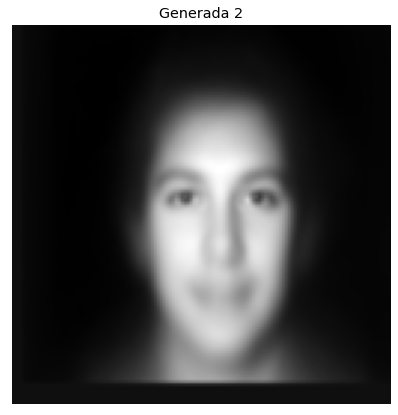

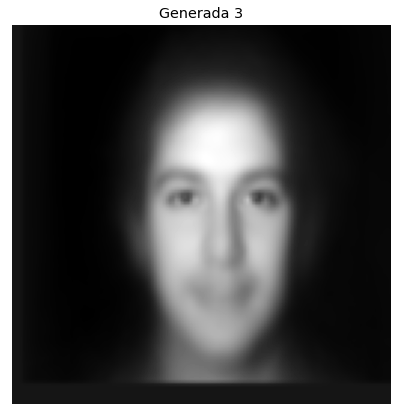

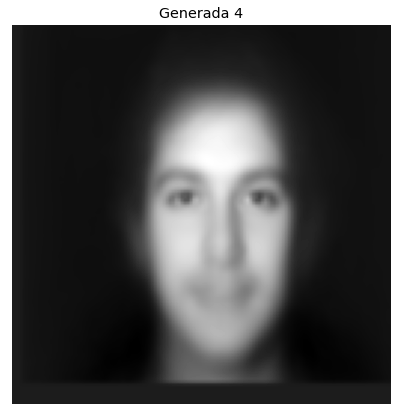

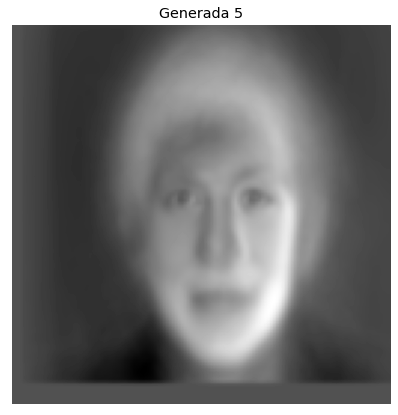

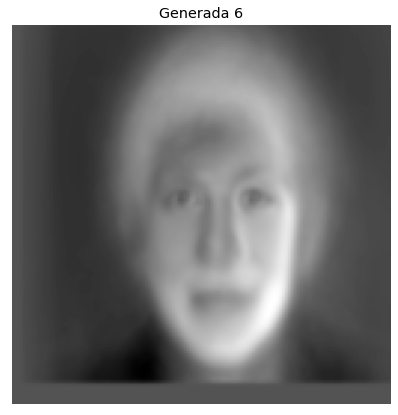

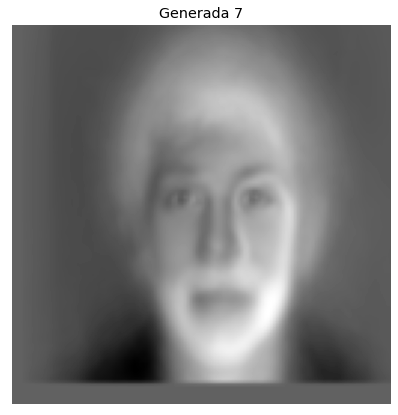

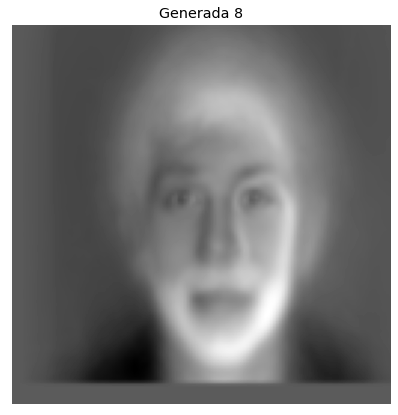

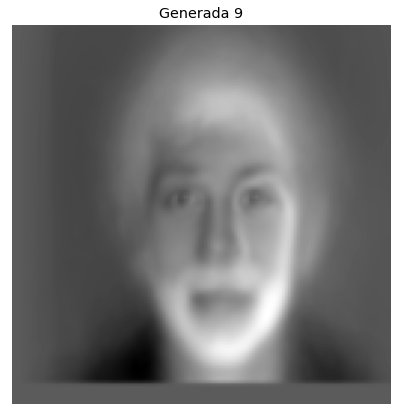

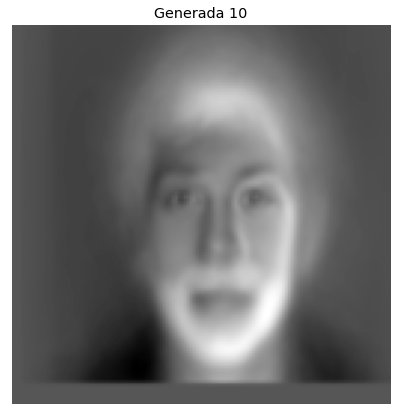

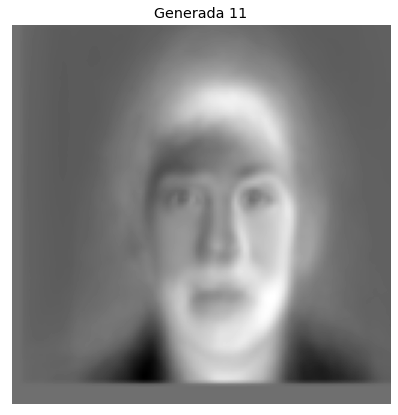

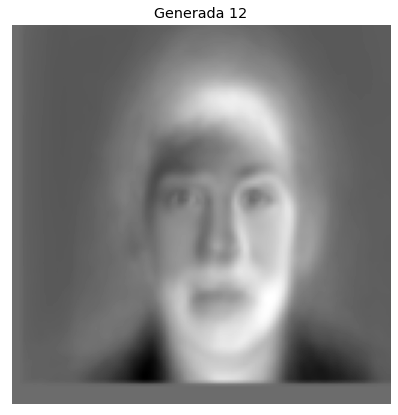

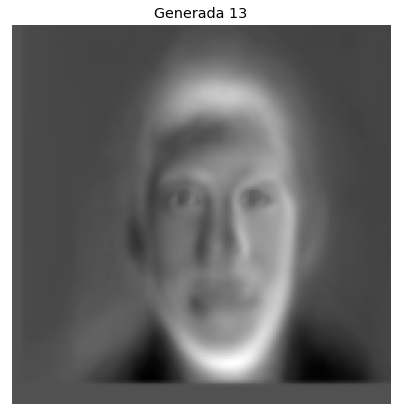

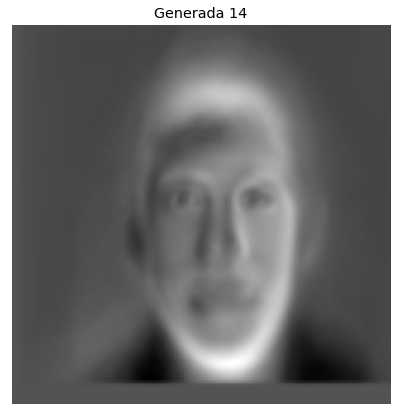

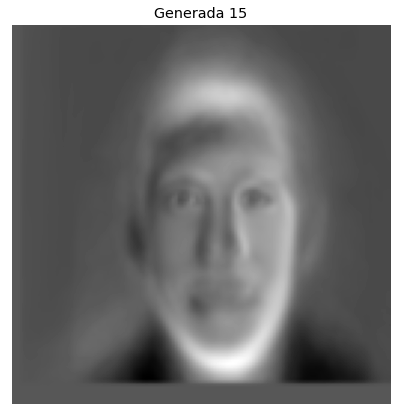

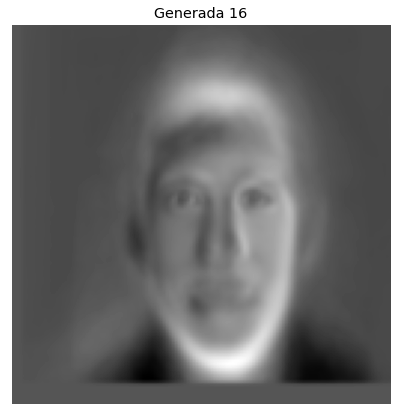

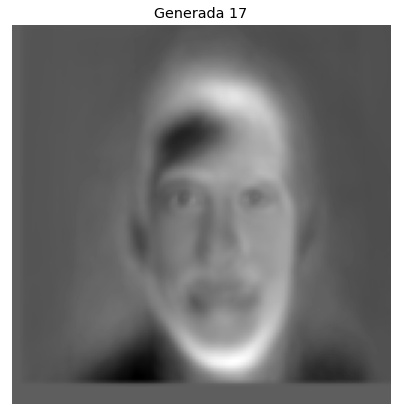

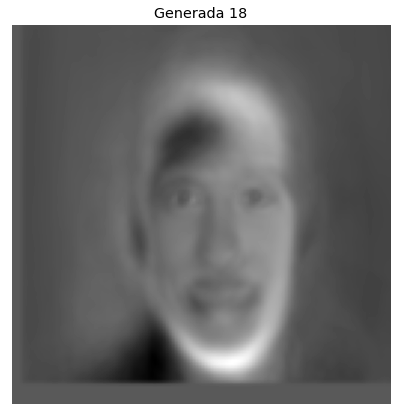

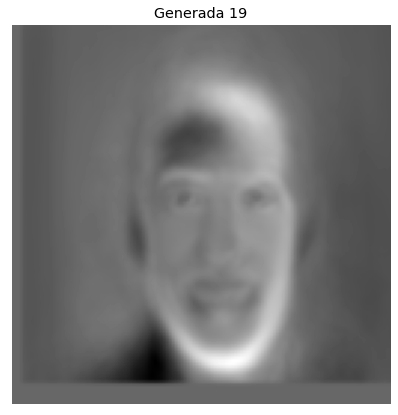

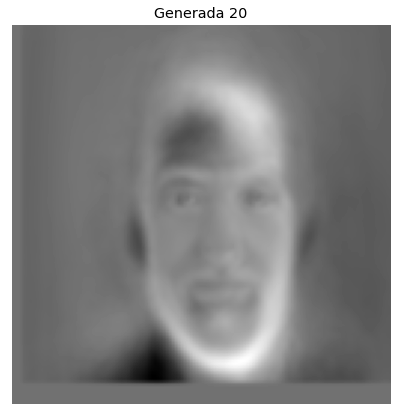

In [ ]:
for i in range(1,20+1):
  imagen = ruido[:i]
  generar(i,imagen)

# Face Morphing
[Referencia](https://colab.research.google.com/github/jckantor/CBE30338/blob/master/docs/A.03-Animation-in-Jupyter-Notebooks.ipynb#scrollTo=OaCGVJ11E01j)

In [ ]:
def generar_rostros_animacion(V_T, menor, mayor, imagen, inverse=False):
  if inverse:
    A = mayor
    B = menor-1
    paso = -1
  else:
    A = menor+1
    B = mayor+1
    paso = 1

  rostrosL = list()
  for i in range(A,B,paso):
    pc = V_T[:i]
    resultado = pc.T@(pc@imagen)
    frame = np.reshape(resultado+mean_face, (128, 128))
    rostrosL.append((frame,i))

  return rostrosL

In [ ]:
rostros = generar_rostros_animacion(V_T, 10, 200, X_centered[0], True)
rostros = rostros + generar_rostros_animacion(V_T, 10, 200, X_centered[1], False)

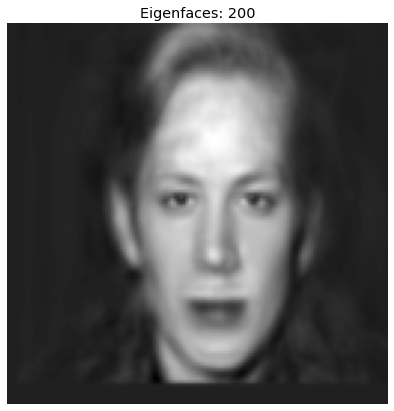

In [ ]:
fig, ax = plt.subplots()
i=0
def init():
  im = ax.imshow(rostros[0][0], cmap="gray")
  ax.set_title("Eigenfaces: "+str(rostros[0][1]))
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.axis('off')
  return im,

def update(frame):
  global i
  i += 1
  im = ax.imshow(rostros[i][0], cmap="gray")
  ax.set_title("Eigenfaces: "+str(rostros[i][1]))
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.axis('off')
  return im,

ani = FuncAnimation(fig, update, frames=range(len(rostros)-2),
                    init_func=init, blit=True)

In [ ]:
from IPython.display import HTML
HTML(ani.to_html5_video())